# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Цель: построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Подготовка к работе

In [1]:
!pip install phik==0.10.0 -q
!pip install -q feature-engine
!pip install -U scikit-learn
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor 
from catboost import CatBoostRegressor, cv, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 123

### Обзор данных

In [5]:
data=pd.read_csv('/datasets/autos.csv', parse_dates=["DateCrawled", "DateCreated", "LastSeen"])

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Последняя дата выгрузки анкеты (год регитсрации автомобиля не может быть позже этой даты)

In [7]:
data['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Типы данных загружены корректно.
Сразу видна необходимость исследовать пропуски в данных.
Столбцы PostalCode, LastSeen, DateCrawled, DateCreated -  не оказывают никакого влияния на ценнобразования, следовательно, на следующем шаге их можно будет удалить.

### Предобработка данных

Столбец NumberOfPictures содержит только нули, его тоже можно удалить

In [9]:
data=data.drop(['PostalCode', 'NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

In [10]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В данных наблюдаются аномальные значения:
- Цена не может равняться 0, так как это целевой признак такого рода аномальные значения необходимо удалить
- Год регистрации не может равняться 1000 или 9999
- Мощность также не может быть 0 или 20000
- Месяц регистрации также не может равняться 0

In [11]:
pd.DataFrame(data.isna().mean()*100).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,10.579368
RegistrationYear,0.000000
Gearbox,5.596709
Power,0.000000
Model,5.560588
Kilometer,0.000000
FuelType,9.282697
Brand,0.000000
Repaired,20.079070


Пропуски будут заполнены при моделировании внутри пайплайна

In [12]:
cat_columns = []
num_columns = []

for col_name in data.columns:

    if isinstance(data[col_name].iloc[0], str):
        cat_columns.append(col_name)
    else:
        num_columns.append(col_name)
num_columns.remove('Price')
print('Count numerical columns:', len(num_columns))
print('Count categorical columns:', len(cat_columns))

Count numerical columns: 5
Count categorical columns: 4


Проверяем категориальные признаки на наличие неявных дубликатов

In [13]:
for col in data.select_dtypes(include='object').columns:
    print('Уникальные значения столбца', col)
    print(data[col].unique(), '\n')

Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Уникальные значения столбца Gearbox
['manual' 'auto' nan] 

Уникальные значения столбца Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_re

Удаляем явные дубликаты

In [14]:
print(data.duplicated().sum())
data=data.drop_duplicates()

45040


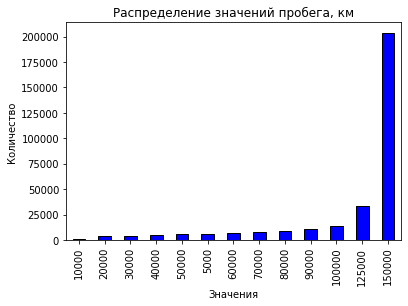

In [15]:
data['Kilometer'].value_counts().sort_values().plot(
        kind='bar', edgecolor='black', alpha = 1, color='blue')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.title('Распределение значений пробега, км');

Признак Пробег является дискретным, поэтому при моделировании отнесем его к категориальным признакам

В данных о мощности очень много выбросов. По результатам поиска в просторах интернетов рекордсмен по мощности 2028 л.с, а минимальное значение установим как 10.

In [16]:
data = data.query('10< = Power <= 2028')

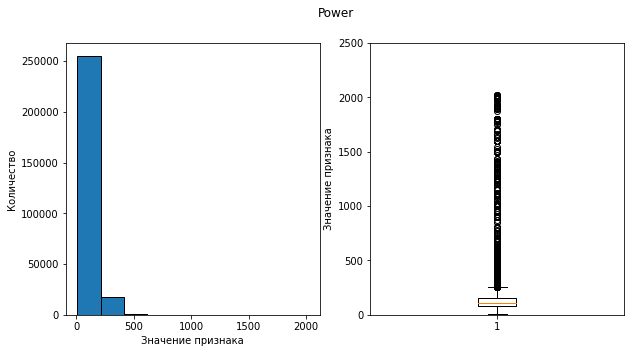

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle('Power')
axes[0].hist(data['Power'], edgecolor='black')
axes[0].set_xlabel('Значение признака')
axes[0].set_ylabel('Количество')
axes[1].boxplot(data['Power'])
plt.ylabel('Значение признака')
plt.ylim([0, 2500]);

Верхнюю границу года регистрации ограничим по максимальному значению столбца даты выгрузки анкет(изучено выше при обзоре данных)

In [18]:
data = data.query('1970<= RegistrationYear <= 2016')

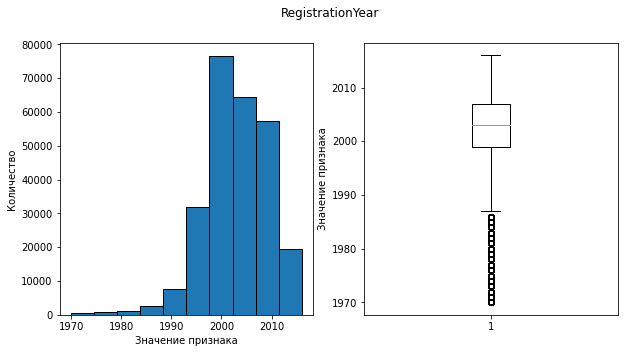

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle('RegistrationYear')
axes[0].hist(data['RegistrationYear'], edgecolor='black')
axes[0].set_xlabel('Значение признака')
axes[0].set_ylabel('Количество')
axes[1].boxplot(data['RegistrationYear'])
plt.ylabel('Значение признака');

### Исследовательский анализ

#### Признаки

Используем корреляцию Phik, так как признаки не распределены нормально, качественные преобладают над количественными, а которые Phik устойчива к выбросам и ненормальному распределению

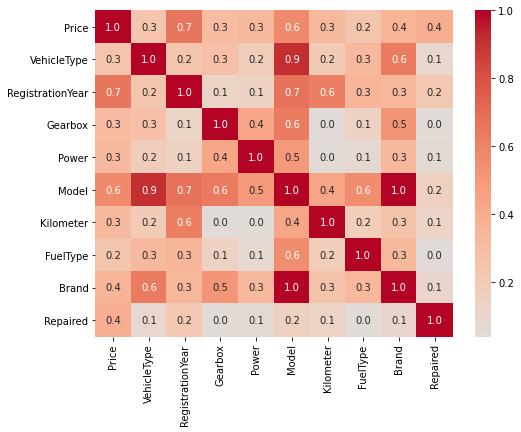

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(data.phik_matrix(interval_cols=['Power', 'Price']),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f");

Мультиколлинеарность признаков наблюдается для Model и Brand, следовательно, при моделировании будем учитывать только один из этих признаков. Также аналогичный высокий коэффициент корреляции 0.9 получен для признаков Model и VehicleType.
С целевым признаком коэффициенты корреляции больше 0.5 имеют RegistrationYear, Model, Kilometer.

#### Целевой признак

In [21]:
data=data.query('Price > 500')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Price', 'Model'], axis=1),
    data['Price'],
    test_size = 0.25, 
    random_state = RANDOM_STATE)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(178236, 8)
(178236,)
(59412, 8)
(59412,)


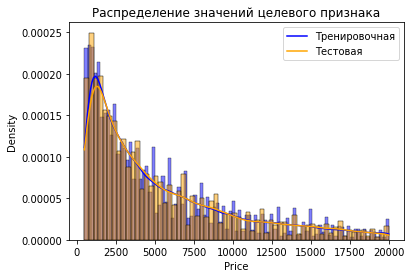

In [24]:
sns.histplot(y_train, stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(y_test, stat='density', common_norm=False, color='orange', kde=True)
labels= ["Тренировочная","Тестовая"]
plt.legend(labels)
plt.title('Распределение значений целевого признака');

Рапределение значений целевого признака на тренировочной и тестовой выборках совпадают. В целевом признаке преобладают низкие значение Цены авто, чем цена выше, тем меньше таких позиций на рынке.

### Вывод
В предоставленных данных признаками являются параметры продаваемых авто, целевой признак - Цена.
Типы данных загружены корректно.

Сразу видна необходимость исследовать пропуски в данных.

Столбцы PostalCode, LastSeen, DateCrawled, DateCreated - не оказывают никакого влияния на ценнобразования, следовательно, их можно будет удалить.

В данных наблюдались аномальные значения:

- Цена не может равняться 0, так как это целевой признак такого рода аномальные значения необходимо удалить
- Год регистрации не может равняться 1000 или 9999
- Мощность также не может быть 0 или 20000
- Месяц регистрации также не может равняться 0
- В данных о мощности очень много выбросов. По результатам поиска в просторах интернетов рекордсмен по мощности 2028 л.с, а минимальное значение установлено как 10.

В данных были удалены явные дубликаты и проведен анализ неявных дубликатов.

По результатам исследовательского анализа признаков:
Мультиколлинеарность признаков наблюдается для Model и Brand, следовательно, при моделировании будем учитывать только один из этих признаков. Также аналогичный высокий коэффициент корреляции 0.9 получен для признаков Model и VehicleType. С целевым признаком коэффициенты корреляции больше 0.5 имеют RegistrationYear, Model, Kilometer.

Данные были разделены на тестовую и тренировочную выборки в отношении 1 к 4. Рапределение значений целевого признака на тренировочной и тестовой выборках совпадают. В целевом признаке преобладают низкие значение Цены авто, чем цена выше, тем меньше таких позиций на рынке.

## Обучение моделей

In [25]:
RMSE = make_scorer(mean_squared_error, greater_is_better=False, squared = False)

In [26]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand']
ord_columns = ['RegistrationYear', 'Kilometer']
num_columns = ['Power']

In [27]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
 
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [28]:
param_grid = [

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LGBMRegressor()
    {'models' : [LGBMRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': [None] + [i for i in range(4, 7)],
     'models__n_estimators': list(range(100, 150, 100)),
     'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [29]:
%%time
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=RMSE,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1*randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Repaired',
                                                   'Brand']),
                      

In [30]:

start = time.time()
best_model = randomized_search.best_estimator_ #получаем лучшую модель из best_estimator

best_model.fit(X_train, y_train) #замеряем время обучения
end = time.time()

model_time_train = (end-start)/60
print('Время обучения лучшей модели на тренировочной выборке', model_time_train)

Время обучения лучшей модели на тренировочной выборке 0.081181534131368


## Анализ моделей

Список всех моделей, участвовавших в моделировании:

In [34]:
df1=pd.DataFrame(randomized_search.cv_results_['params']).astype(str)
df2=(pd.DataFrame(randomized_search.cv_results_)
  [['mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
     )
result=pd.concat([df1, df2], axis=1).sort_values(
    by=['mean_fit_time', 'mean_score_time'], ascending=(True, True)).reset_index(drop=True)
result

,preprocessor__num,models__n_estimators,models__max_depth,models,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
0,StandardScaler(),nan,nan,LinearRegression(),-2965.449314,9,1.544551,0.239975
1,MinMaxScaler(),nan,nan,LinearRegression(),-2965.449314,9,1.607811,0.238468
2,passthrough,100.0,4.0,LGBMRegressor(random_state=123),-1853.705923,7,3.158625,0.305488
3,MinMaxScaler(),100.0,5.0,LGBMRegressor(random_state=123),-1792.122902,5,3.417792,0.399379
4,passthrough,100.0,5.0,LGBMRegressor(random_state=123),-1792.122902,5,3.572978,0.345109
5,MinMaxScaler(),100.0,4.0,LGBMRegressor(random_state=123),-1853.705923,7,3.688233,0.344059
6,StandardScaler(),100.0,5.0,LGBMRegressor(random_state=123),-1791.048667,4,3.937633,0.437694
7,StandardScaler(),100.0,nan,LGBMRegressor(random_state=123),-1729.645861,3,4.556921,0.440498
8,MinMaxScaler(),100.0,nan,LGBMRegressor(random_state=123),-1728.221259,1,4.777894,0.466873
9,passthrough,100.0,nan,LGBMRegressor(random_state=123),-1728.221259,1,5.180982,0.446333


Параметры и время обучения и предсказания для лучших моделей:

In [35]:
result.iloc[result.groupby('models')['mean_test_score'].idxmax()].sort_values(by=['mean_test_score'], ascending=(False))

,preprocessor__num,models__n_estimators,models__max_depth,models,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
8,MinMaxScaler(),100.0,nan,LGBMRegressor(random_state=123),-1728.221259,1,4.777894,0.466873
0,StandardScaler(),nan,nan,LinearRegression(),-2965.449314,9,1.544551,0.239975


### Проверка модели на тестовых данных

In [37]:
pred = best_model.predict(X_test)
RMSE=mean_squared_error(y_test, pred)** 0.5
print(f'Метрика на тестовой выборке:', RMSE)
end = time.time()

model_time_pred = (end-start)/60
print('Время предсказания лучшей модели на тестовой выборке', model_time_pred)

Метрика на тестовой выборке: 1730.1488013971189
Время предсказания лучшей модели на тестовой выборке 0.09457765022913615


In [38]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 
print(f'Метрика на константной модели: {mean_squared_error(y_test, y_predict_dummy_mean)** 0.5}')

Метрика на константной модели: 4638.995807419353


Метрика на константной модели хуже, чем на тестовой выборке

### Итоговый вывод

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Цель: построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В предоставленных данных признаками являются параметры продаваемых авто, целевой признак - Цена.
Типы данных загружены корректно.

Сразу видна необходимость исследовать пропуски в данных.

Столбцы PostalCode, LastSeen, DateCrawled, DateCreated - не оказывают никакого влияния на ценнобразования, следовательно, их можно будет удалить.

В данных наблюдались аномальные значения:

- Цена не может равняться 0, так как это целевой признак такого рода аномальные значения необходимо удалить
- Год регистрации не может равняться 1000 или 9999
- Мощность также не может быть 0 или 20000
- Месяц регистрации также не может равняться 0
- В данных о мощности очень много выбросов. По результатам поиска в просторах интернетов рекордсмен по мощности 2028 л.с, а минимальное значение установлено как 10.

В данных были удалены явные дубликаты и проведен анализ неявных дубликатов.

По результатам исследовательского анализа признаков:
Мультиколлинеарность признаков наблюдается для Model и Brand, следовательно, при моделировании будем учитывать только один из этих признаков. Также аналогичный высокий коэффициент корреляции 0.9 получен для признаков Model и VehicleType. С целевым признаком коэффициенты корреляции больше 0.5 имеют RegistrationYear, Model, Kilometer.

Данные были разделены на тестовую и тренировочную выборки в отношении 1 к 4. Рапределение значений целевого признака на тренировочной и тестовой выборках совпадают. В целевом признаке преобладают низкие значение Цены авто, чем цена выше, тем меньше таких позиций на рынке.

Моделирование было проведено с помощью модели градиентного бустинга LGBM, а также с помощью модели линейной регрессии. 

Наилучшей моделью оказалась модель 
С параметрами {'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 100, 'models__max_depth': None, 'models': LGBMRegressor(random_state=123)}

Лучшее значение метрики RMSE на тестовых данных равно: 1730.1488013971189

